In [9]:
!pip install chronos-forecasting
import pandas as pd  # requires: pip install pandas
import numpy as np
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt

# Testing base chronos model on Chaotic Systems

- Chronos outputs am evenly spaced quantile prediction at {0.1, 0.2, ... 0.9}
- WqL: input all quantiles -> outputs a loss value
- MASE: input a single quantile (standardize at 0.5) -> outputs a loss value

In [19]:
#WQL FUNCTION (Sourced from chatGPT)


def quantile_loss(y_true, y_pred, alpha):
    """
    Computes quantile loss for a given quantile level alpha.
    
    Parameters:
    - y_true: True values (numpy array of shape (N,))
    - y_pred: Predicted quantile values (numpy array of shape (N,))
    - alpha: Quantile level (scalar)

    Returns:
    - Quantile loss (scalar)
    """
    diff = y_true - y_pred
    return np.maximum(alpha * diff, (alpha - 1) * diff).mean()

def weighted_quantile_loss(y_true, y_pred_quantiles, quantile_levels):
    """
    Computes the Weighted Quantile Loss (WQL) with the modified shape of predictions.

    Parameters:
    - y_true: True values (numpy array of shape (N,))
    - y_pred_quantiles: Predicted quantiles (numpy array of shape (K, N), where K is the number of quantiles)
    - quantile_levels: List or array of quantile levels (K,)

    Returns:
    - Weighted Quantile Loss (scalar)
    """
    assert y_pred_quantiles.shape[0] == len(quantile_levels), "Mismatch in quantile dimensions"

    # Compute WQL for each quantile
    wql_per_quantile = [
        (2 * quantile_loss(y_true, y_pred_quantiles[j, :], alpha)) / np.abs(y_true).sum()
        for j, alpha in enumerate(quantile_levels)
    ]
    
    # Final WQL (mean over quantiles)
    return np.mean(wql_per_quantile)

In [16]:
#MASE 
def mase(y_true, y_pred, y_past, S):
    """
    Computes the Mean Absolute Scaled Error (MASE) based on the provided formula.

    Parameters:
    - y_true: Actual values (numpy array of shape (H,))
    - y_pred: Predicted values (numpy array of shape (H,))
    - y_past: Historical values (numpy array of shape (C,)) for computing seasonal naive MAE
    - S: Seasonality parameter (integer)

    Returns:
    - MASE score (scalar)
    """
    C = len(y_past)  # Context length
    H = len(y_true)  # Prediction horizon

    # Compute the numerator (MAE of forecast)
    numerator = np.sum(np.abs(y_pred - y_true)) / H

    # Compute the denominator (MAE of seasonal naive forecast)
    denominator = np.sum(np.abs(y_past[:-S] - y_past[S:])) / (C - S)

    return numerator / denominator if denominator != 0 else np.inf

In [2]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-mini",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"
)

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# Chronos-Bolt models generate quantile forecasts, so forecast has shape
# [num_series, num_quantiles, prediction_length].
forecast = pipeline.predict(
    context=torch.tensor(df["#Passengers"].iloc[:-12]), prediction_length=12
)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [27]:
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


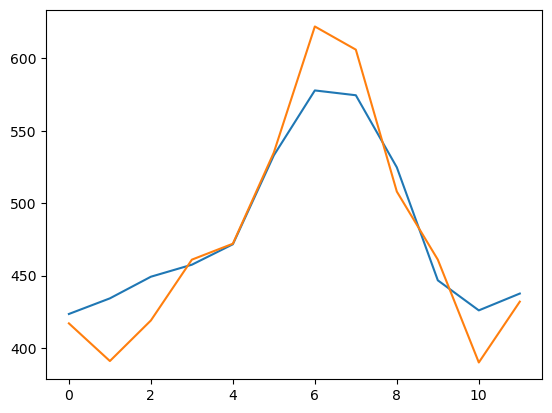

In [26]:
plt.plot(forecast[0][4],label='forecast')
plt.plot(df["#Passengers"].iloc[-12:].to_numpy())

In [22]:
quantiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
weighted_quantile_loss(df["#Passengers"].iloc[-12:].to_numpy(), forecast[0].numpy(), quantiles)

0.002806450351724039

In [32]:
mase(df["#Passengers"].iloc[-12:].to_numpy(), forecast[0][4].numpy(), df["#Passengers"].iloc[:-12].to_numpy(), 12)

0.6404895500596521